In [ ]:
#we detect faces from a random input noisy and low resolution image
#we are using haar cascade classifier of opencv2 to detect the faces from our image
#it is a pre trained classifier, so we are using transfer learning to detect faces as my device hardware isn't enough to train a custom model

#we import all the necessary modules
import numpy as np
import cv2
import sys
import dlib
import os

#we read an test image of the AT&T facedata base which is grainy and low resolution
image = cv2.imread('/content/Input/Images-from-the-AT-T-database.png')


#we initialize the haar classifier and run it on the image data 
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(image,scaleFactor=1.05,minNeighbors=3,minSize=(30, 30))

#haar classifier detects faces using rectangle and saves them in haar_face folder
print("Found {0} Faces!".format(len(faces)))
i=0
for (x, y, w, h) in faces:
    
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 1)
    crop = image[y:y + h, x:x + w]
    cv2.imwrite('/content/haar_face/'+str(i) + '_face.jpg', crop)
    i=i+1
print("Faces detected were saved. This was done by haar classifier.")


#we detect faces from a random input noisy and low resolution image
#we are using frontal face detetcor of dlib to detect the faces from our image
#it is a pre trained classifier, so we are using transfer learning to detect faces as my device hardware isn't enough to train a custom model
#we use this as haar classifier of open cv is prone to false positives, so we use another pre trained classifier to find images
#we read an test image of the AT&T facedata base which is grainy and low resolution and taken from internet
#we initialize the detector and run it on the image data 
detector = dlib.get_frontal_face_detector()
img = cv2.imread('/content/Input/Images-from-the-AT-T-database.png')
dets = detector(img, 1)

#we then iterate through dimensions of all faces detected and save them in dlib_face folder
#we use a try and exception part here as frontal detector sometimes gives negative coordinates   
for i, d in enumerate(dets):
  try:
        cv2.imwrite('/content/dlib_face/'+str(i) + '_face.jpg', img[d.top():d.bottom(), d.left():d.right()])
  except Exception:
        pass

print("{0} Faces were detected by dlib".format(len(dets)))
print("Faces detected were saved")

Found 14 Faces!
Faces detected were saved. This was done by haar classifier.
15 Faces were detected by dlib
Faces detected were saved


15 Faces were detected
Faces detected were saved


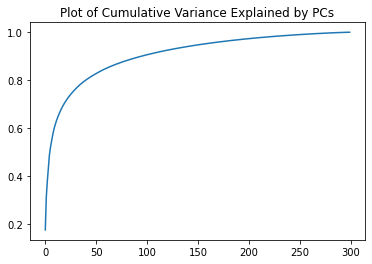

Percentage variance explained by 100 PC: 90.62179165126265


In [ ]:
#Part 2 of Project 2 - Face Recognisation by PCA + SVM. By Amlan (MS18197) and Dhananjay(MS18065). Equal Contribution.
#In this code, we first take our original database and perform PCA. We then run it through a svm classifier to improve our detection results.


import zipfile
import sys
import os
import cv2
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.svm import SVC


# Read face image from zip file
faces = {}
with zipfile.ZipFile("archive.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # we read the image as and save it as a grayscale image
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

classes = set(filename.split("/")[0] for filename in faces.keys())

# Intialise two lists, one for labels from filenames and other for image data to find for eigenfaces
facematrix = []
facelabel = []

#we make a a matrix of all images, each straightened into a column
#we use regex to find the classes numbers and saved it in facelabel

for key,val in faces.items():
    facematrix.append(val.flatten())
    facelabel.append(int(re.findall(r'-?\d+\.?\d*', key.split("/")[0])[0]))

#we create the matrix of the face data
facematrix = np.array(facematrix)

#we split data into test & train sets
x_train, x_test, y_train, y_test = train_test_split(facematrix, facelabel)

#we get the eigenfaces from PCA method
pca = PCA().fit(x_train)

#plotting the cumulative variation explained with nos of PC
#we use this to find the no. of required PC to explain 80-90% variation 
var_cumul = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cumul)
plt.title('Plot of Cumulative Variance Explained by PCs')
plt.show()

#appropriate PC is 100, we have reduced dimensions from 400 to 100 now, which is a huge decrease
print("Percentage variance explained by 100 PC:",100*var_cumul[100])

#choosing n=100
pca = PCA(n_components = 100).fit(x_train)


#eigenfaces matrix
eigenfaces = pca.components_

#weights of the original data projected onto PCs
train_weights = pca.transform(x_train) 

#We use randomized search cross validation to perform a heurestic optimization of hyperparameters. Normal grid search takes a lot more time.
params={
 'C': [1,10,100,250,500,750,1000],
    'kernel': ['rbf','linear'],
    'gamma' : [0.00001,0.0001,0.001,0.01,0.1,1]}

clf=RandomizedSearchCV(SVC(),param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
clf.fit(train_weights,y_train)
print("Best Accuracy Score for Parameter search is",100*clf.best_score_)
print('Best Parameters are: ',clf.best_params_)

#from the best hyperparameters, we train our model again
#we fit the PC transformed train dataset
model = SVC(C=1,kernel='linear',gamma=0.0001)
model.fit(train_weights,y_train)

#we then find the PC transformed test dataset 
#we predict the results of the model and find an accuracy of 98pc on test dataset
test_weights = pca.transform(x_test)
y_pred = model.predict(test_weights)
confusion_matrix(y_test, y_pred)
print('The accuracy score for the SVM is ',accuracy_score(y_test, y_pred))

#we then iterate through the images of haar classifier 
directory = '/content/haar_face/'

#we define a dataframe to take attendance. For each image identified it puts 1 in the entry of dataframe
df = pd.DataFrame(columns=['Person','Attendance'])
df['Person'] = [i for i in range(1,41)]
df.set_index('Person',inplace=True)


# we loop through the directory of haar detected images.
#we first scale up the detected images and convert them into grey scale
#we then project them into PCs and use svm model to predict the class of the image
#we update the attendance dataframe accordingly.
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      test = cv2.imread(directory + str(filename), cv2.IMREAD_GRAYSCALE)
      scale_up_y = 112/test.shape[0]
      scale_up_x = 92/test.shape[1]
      faceshape = (112,92)
      test = cv2.resize(test, None, fx= scale_up_x, fy= scale_up_y).reshape(1,-1) #, interpolation= cv2.INTER_LINEAR
      input = test
      input_weight = pca.transform(input)
      best_match = model.predict(input_weight)
      person = facelabel.index(best_match)
      df.loc[int(best_match),'Attendance'] = 1
    else:
      continue

df.to_excel("Attendance.xlsx")  # saves our attendance dataframe as a excel sheet

In [ ]:
#choosing n=150
pca = PCA(n_components = 100).fit(x_train)

eigenfaces = pca.components_





In [ ]:
train_weights.shape

(300, 100)

In [ ]:
#PCA + Support Vector Machines Method
import os
directory = '/content/haar_face/'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      test = cv2.imread(directory + str(filename), cv2.IMREAD_GRAYSCALE)
      scale_up_y = 112/test.shape[0]
      scale_up_x = 92/test.shape[1]
      faceshape = (112,92)
      test = cv2.resize(test, None, fx= scale_up_x, fy= scale_up_y).reshape(1,-1) #, interpolation= cv2.INTER_LINEAR
      input = test
      input_weight = pca.transform(input)
      best_match = model.predict(input_weight)
      person = facelabel.index(best_match)
      print("Best match is Person No. ",best_match[0])
      # Visualize
      fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
      axes[0].imshow(input.reshape(faceshape), cmap="gray")
      axes[0].set_title("Input")
      axes[1].imshow(facematrix[person].reshape(faceshape), cmap="gray")
      axes[1].set_title("Best match")
      plt.show()
    else:
      continue

In [ ]:
#We use randomized search cross validation to perform a heurestic optimization of hyperparameters. 


params={
 'C': [1,10,100,250,500,750,1000],
    'kernel': ['rbf','linear'],
    'gamma' : [0.00001,0.0001,0.001,0.01,0.1,1]}

clf=RandomizedSearchCV(SVC(),param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
clf.fit(train_weights,y_train)
print("Best Accuracy Score for Parameter search is",100*clf.best_score_)
print('Best Parameters are: ',clf.best_params_)

model = SVC(C=1,kernel='linear',gamma=0.0001)
model.fit(train_weights,y_train)

test_weights = pca.transform(x_test)
y_pred = model.predict(test_weights)
confusion_matrix(y_test, y_pred)
print('The accuracy score for the SVM is ',accuracy_score(y_test, y_pred))

import os
directory = '/content/haar_face/'


df = pd.DataFrame(columns=['Person','Attendance'])
df['Person'] = [i for i in range(1,41)]
df.set_index('Person',inplace=True)



for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      test = cv2.imread(directory + str(filename), cv2.IMREAD_GRAYSCALE)
      scale_up_y = 112/test.shape[0]
      scale_up_x = 92/test.shape[1]
      faceshape = (112,92)
      test = cv2.resize(test, None, fx= scale_up_x, fy= scale_up_y).reshape(1,-1) #, interpolation= cv2.INTER_LINEAR
      input = test
      input_weight = pca.transform(input)
      best_match = model.predict(input_weight)
      person = facelabel.index(best_match)
      df.loc[int(best_match),'Attendance'] = 1
    else:
      continue

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


Best Accuracy Score for Parameter search is 97.99999999999999
Best Parameters are:  {'kernel': 'linear', 'gamma': 0.001, 'C': 1000}
The accuracy score for the SVM is  0.94


In [ ]:
print(df)

       Attendance
Person           
1               1
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13              1
14            NaN
15            NaN
16            NaN
17            NaN
18              1
19              1
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
30            NaN
31            NaN
32            NaN
33            NaN
34            NaN
35            NaN
36            NaN
37            NaN
38            NaN
39            NaN
40            NaN


,Attendance
Person,
1,1
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


Best match is Person No.  1


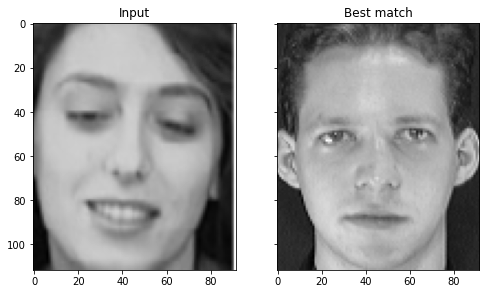

Best match is Person No.  1


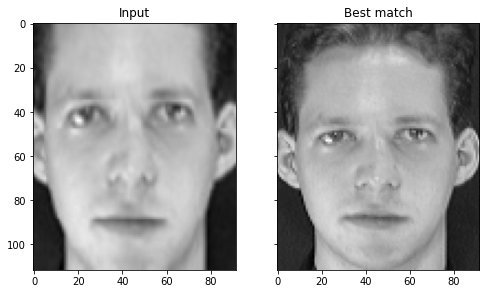

Best match is Person No.  5


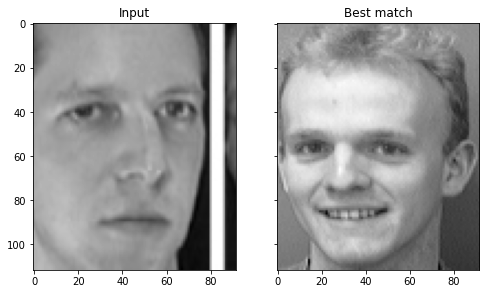

Best match is Person No.  18


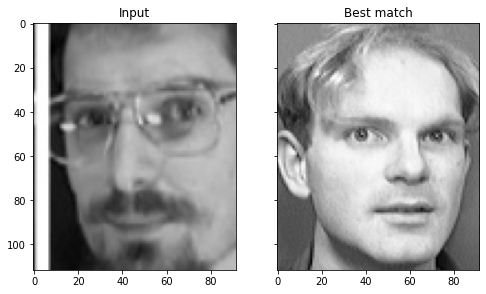

Best match is Person No.  1


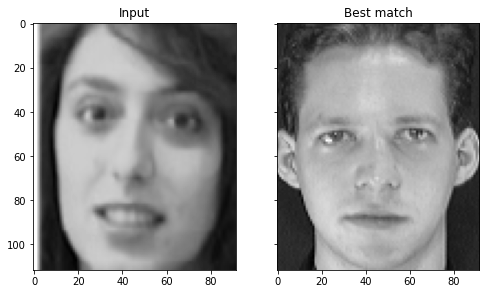

Best match is Person No.  18


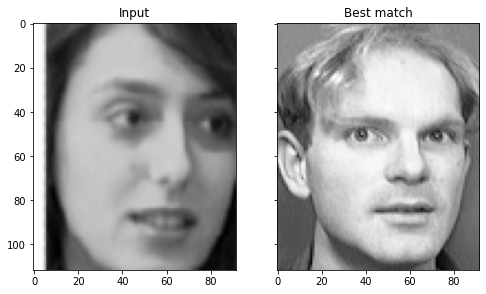

Best match is Person No.  18


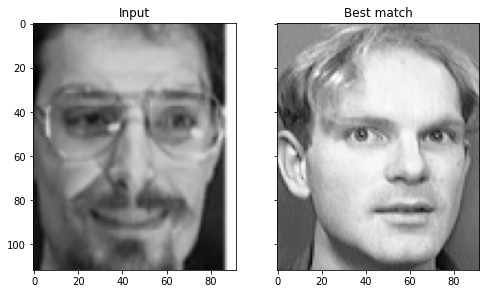

Best match is Person No.  1


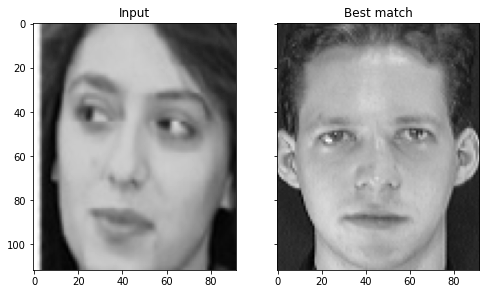

Best match is Person No.  1


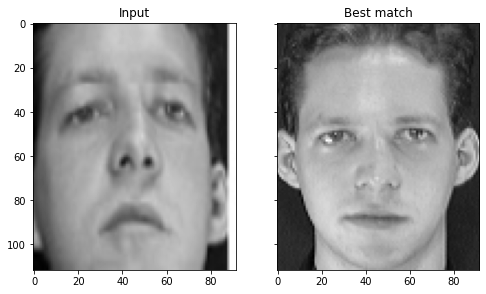

Best match is Person No.  1


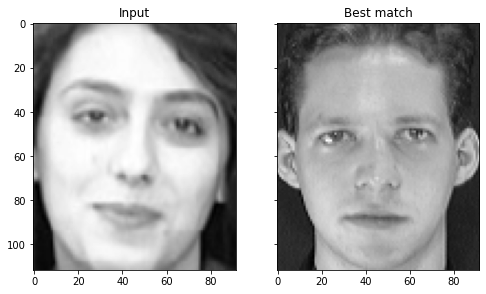

Best match is Person No.  1


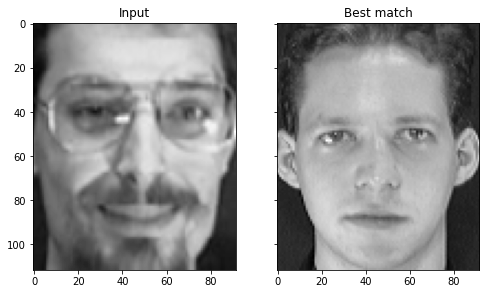

Best match is Person No.  1


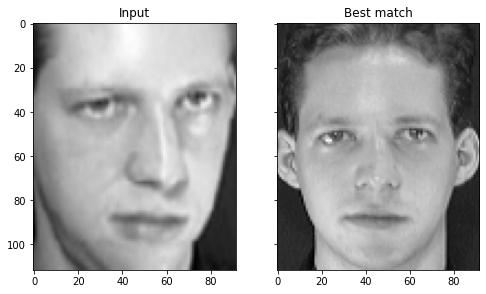

Best match is Person No.  19


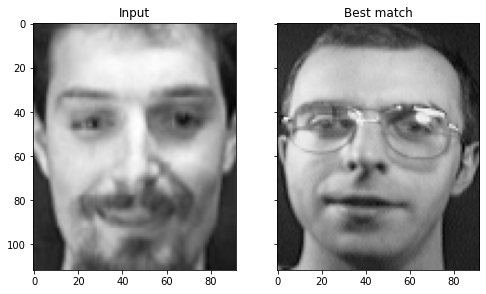

Best match is Person No.  5


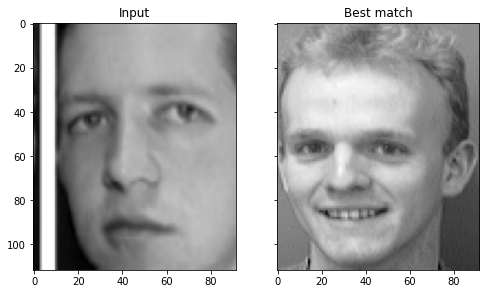

In [ ]:
import os
directory = '/content/haar_face/'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      test = cv2.imread(directory + str(filename), cv2.IMREAD_GRAYSCALE)
      scale_up_y = 112/test.shape[0]
      scale_up_x = 92/test.shape[1]
      faceshape = (112,92)
      test = cv2.resize(test, None, fx= scale_up_x, fy= scale_up_y).reshape(1,-1) #, interpolation= cv2.INTER_LINEAR
      input = test
      input_weight = pca.transform(input)
      best_match = model.predict(input_weight)
      person = facelabel.index(best_match)
      print("Best match is Person No. ",best_match[0])
      # Visualize
      fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
      axes[0].imshow(input.reshape(faceshape), cmap="gray")
      axes[0].set_title("Input")
      axes[1].imshow(facematrix[person].reshape(faceshape), cmap="gray")
      axes[1].set_title("Best match")
      plt.show()
    else:
      continue

In [ ]:
test

Best match is Person No.  15


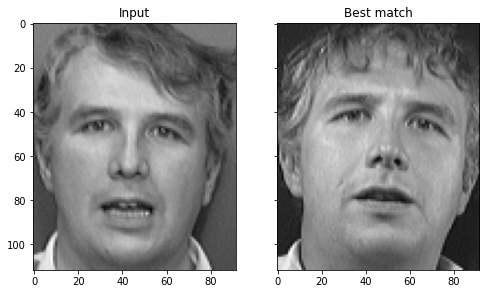

Best match is Person No.  24


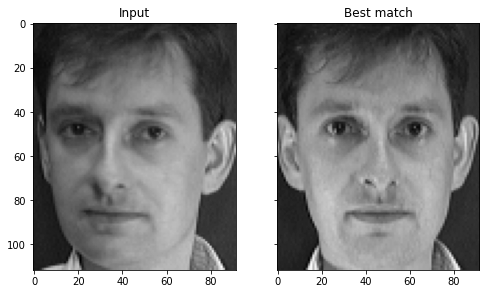

Best match is Person No.  24


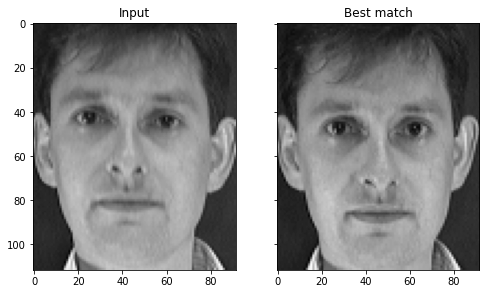

Best match is Person No.  23


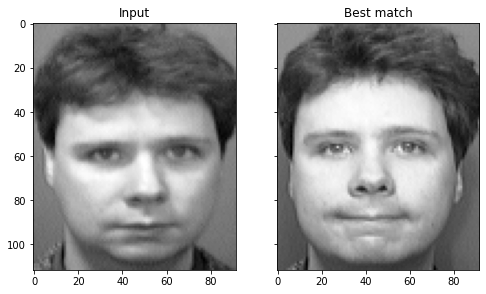

Best match is Person No.  21


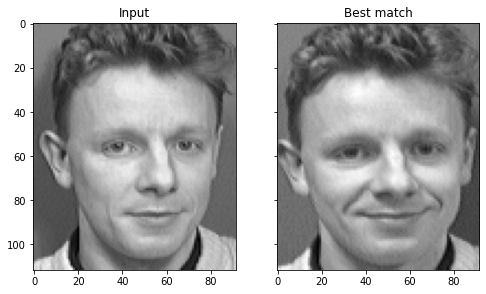

Best match is Person No.  34


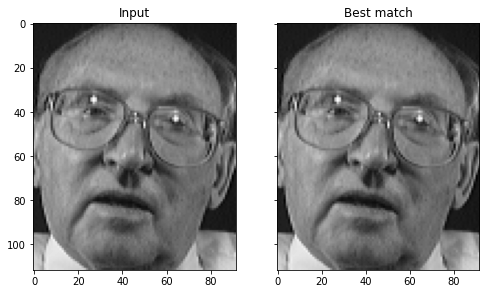

Best match is Person No.  16


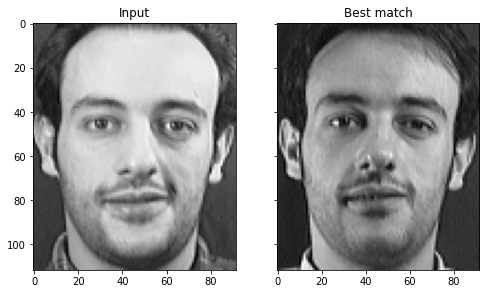

Best match is Person No.  28


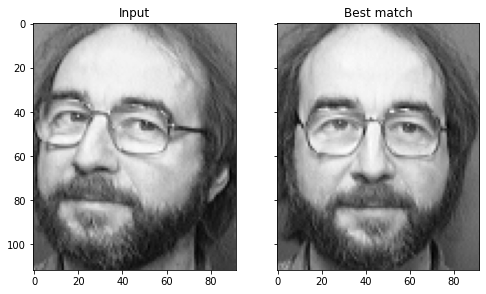

Best match is Person No.  25


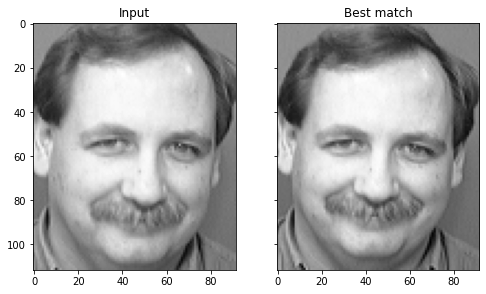

Best match is Person No.  13


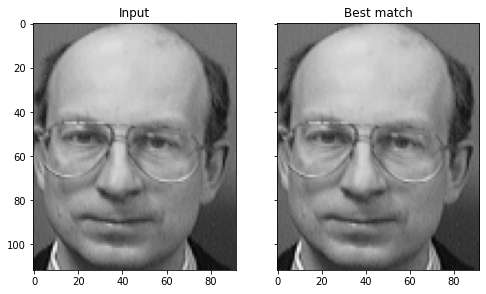

In [ ]:
for i in range(10):
      test = x_test[i]
      input = test.reshape(1, -1)
      input_weight = pca.transform(input)
      best_match = model.predict(input_weight)
      person = facelabel.index(best_match)
      print("Best match is Person No. ",best_match[0])
      # Visualize
      fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
      axes[0].imshow(input.reshape(faceshape), cmap="gray")
      axes[0].set_title("Input")
      axes[1].imshow(facematrix[person].reshape(faceshape), cmap="gray")
      axes[1].set_title("Best match")
      plt.show()

In [ ]:
test.shape

(10304,)